# Одни характеристики - Разные формы

#### Цель
Цель этого ноутбука -- повторить результат следущей статьи:

https://www.autodesk.com/research/publications/same-stats-different-graphs

В этой статье показывается, что возможно кардинально менять расположение точек на плоскости, не меняя их основных статистик(с точностью до двух знаков после запятой) -- средних, стандартных отклонений и коэффициента корреляции пирсона. Если быть более точным, авторам статьи удалось большее -- они научились строить из точек произвольные фигуры:

![title](img/AllDinosGrey_1.png)

#### Реализация

Идея заключается в применении метода симуляции отжига к случайным маленьнким колебаниям точек, которые не меняют статистик.

В этом ноутбуке в качестве начальной фигуры выбран динозавр, а конечной фигуры(которую мы будем называть в коде идеалом(ideal)) выбран эллипс:

![title](img/dino_elips.png)

Чтобы получить желаемый результат нужно ответить на следующие вопросы:
1. Как осуществлять случайные колебания точек?
2. Какую выбрать температуру для метода отжига?
3. Какую выбрать функцию вероятности для метода отжига?
4. Какие наборы точек мы считаем похожими? Как оценить сходство наборов точек математическим путем, т.е. как выбрать правильную целевую функцию для метода оптимизации?

На все эти вопросы были получены ответы и достигнут требуемый результат:

![title](img/result.png)

#### Вопрос 1: Как осуществлять случайные колебания точек?

Ответ: Опытным путем было установлено, что увеличение дисперсии случайного равномерного смещения ведёт к уменьшению вероятности того, что смещение окажется приемлимым(т.е. не изменит значения статистик), что ведёт к увеличению длительности работы алгоритма. Поэтому было решено делать несколько маленьких равномерных смещений, последовательное применение которых, очевидно, не меняет статистик, но зато образует 
одно большое смещение. В коде это 10 маленьких равномерных колебаний от (-0.1 до 0.1)

#### Вопрос 2: Как выбрать выбрать температуру для метода отжига? 

Ответ: функция тепературы: $t(i) = \frac{1000}{i}$, где $i$ - номер итерации.

#### Вопрос 3: Какую выбрать функцию вероятности для метода отжига?

Ответ: функция вероятности перехода: $ e^{-\frac{\delta}{t}} $, где $t$ - текущая температура, $\delta$ - разность между значением целевой функции до последнего смещения и значением целевой функции после смещения

#### Вопрос 4: Какие наборы точек мы считаем похожими? Как оценить сходство наборов точек математическим путем, т.е. как выбрать правильную целевую функцию для метода оптимизации?

Терминология: 
1. Идеал - набор точек, к которому мы стремимся. В данном случае это эллипс из точек.
2. Оцениваемый набор - набор точек, который мы сравниваем c идеалом, т.е. аргумент целевой функции.

Ответ: 

В первой попытке в качестве целевой функции была выбрана tarfun1. Она последовательно для каждой точки идеала(эллипса) выбирает ближайшую точку из оцениваемого набора точек, которую не выбрали на предыдущих итерациях. Пример. Для первой точки из идеала она выберет ближайшую точку из оцениваемого набора. Для второй точки идеала выберет ближайшую точку из оцениваемого набора, из которого убрали точку выбранную для первой точки идеала. И так далее. Таким образом, получается инъекция из идеала в оцениваемого набор.

Вот несколько кадров. Для просмотра анимации перейдите к соответсвтующей ячейке
![title](img/tarfun1(2).png)
![title](img/tarfun1(3).png)

Однако данная целевая функция имеет недостатки: она не инвариантна относительно последовательности выбора точек в идеале, маленькие изменения в оцениваемом наборе иногда приводят к большому изменению значения целевой функции(сотни или тысячи)(это происходит из-за того что даже небольшие колебания меняют выбор ближайших точек)

Во второй попытке была рассмотрена целевая функция tarfun2. Она для каждой точки идеала выбирает ближайшую точку из оцениваемого набора. tarfun2 похожа на tarfun1, отличие заключается в том, что теперь две точки из идеала могут выбрать одну и ту же точку из оцениваемого набора. 

Недостаток такой целевой функции заключается в том, что если несколько точек из оцениваемого набора  удачно расположены, то они будут ближайшими для многих точек из идеала, и, следовательно, только они будут вносить вклад, тогда как местоположение других точек из оцениваемого набора не будет сильно влиять на значение целевой функции.

Чтобы исправить этот недостаток была придумана функция tarfun3, которая будет штрафовать точки из оцениваемого набора, которые далеко расположены от идеала. Она аналогична tarfun2, но теперь для каждой точки из ОЦЕНИВАЕМОГО НАБОРА ищется ближайшая точка из ИДЕАЛА, т.е. идеал поменялся местами с оцениваемым набором. 

Так как функция tarfun3, является копией tarfun2, в котороя поменяли местами идеал с оцениваемым набором, то она подвержена тем же проблемам, что и tarfun2.

Чтобы исправить этот недостаток, была придумана функция tarfun4, которая является суммой tarfun2 и tarfun3. На практике она оказалась довольной удачной.

#### Заключение

Нам удалось добиться требуемых результатов. Работа показала, что стохастические методы оптимизации -- мощный инструмент, с помощью которого можно решать нетривиальные задачи и получать хороший результат.

#### Подключаем библиотеки и прочие предварительные настройки:

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('seaborn')

#### График точек:

In [2]:
xlim = (0, 100)
ylim = (0, 100)

def scatter(points, col='red'):
    plt.scatter(points[:, 0], points[:, 1], c=col)
    plt.xlim(xlim)
    plt.ylim(ylim)

#### Процедура получения основных статистических характеристик:

In [3]:
def getstats(points):
    return np.hstack((np.mean(points, axis=0), np.std(points, axis=0), np.corrcoef(points[:, 0], points[:, 1])[0][1]))


def roundstats(stats):
    return np.vectorize(lambda x: round(x, 2)) (stats)

#### Загружаем набор точек на плоскости, которые мы в дальнейшем будем двигать, не меняя(до 2 знаков после запятой) основные статистические свойства. Загружаем набор точек, к которому мы будем стремиться:

array([54.26327324, 47.83225282, 16.70600555, 26.84039295, -0.06447185])

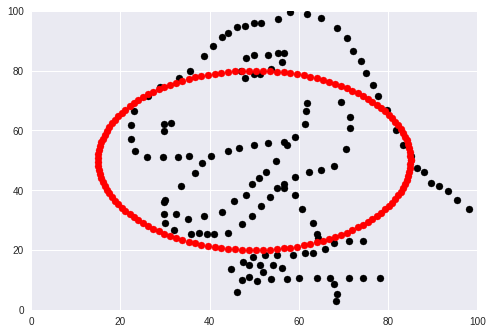

In [4]:
data = pd.read_csv('data/Datasaurus_data.csv', names=['x', 'y'])
dino = data.values
scatter(dino, col='black')
dinostats = getstats(dino)

ideal = np.load('elips.npy')
scatter(ideal, col='red')

dinostats

#### Функции расстояний между двумя точками, Целевые функции

In [5]:
def eu_dist(x1, x2, y1, y2):
    '''Евлклидово расстояние'''
    return math.sqrt( (x1-x2)*(x1-x2) + (y1-y2)*(y1-y2) )


def sqr_dist(x1, x2, y1, y2):
    '''Квадрат расстояния'''
    return (x1-x2)*(x1-x2) + (y1-y2)*(y1-y2)


def tarfun1WithDistances(ideal, xy, dist_fun = eu_dist):
    '''
    Пробегаемся по всем точкам в идеале, и выбираем ближайшую точку
    из xy без возврата, считаем расстояние и прибавляем его.
    Возвращает значение + расстояния + порядок выбора ближайших точек
    '''
    n = xy.shape[0]
    isFree = np.full(n, True)
    distances = np.zeros(n)
    min_args = np.zeros(n, dtype=int)
    s = 0
    for i in range(n):
        min_ind = -1
        min_dist = np.inf
        for j in range(n):
            if isFree[j]:
                d = dist_fun(ideal[i][0], xy[j][0], ideal[i][1], xy[j][1])
                if min_ind == -1 or d < min_dist:
                    min_dist = d
                    min_ind = j
        isFree[min_ind] = False
        s += min_dist
        distances[i] = min_dist
        min_args[i] = min_ind
    return s, distances, min_args


def tarfun1(ideal, xy, dist_fun = eu_dist):
    '''
    Пробегаемся по всем точкам в идеале, и выбираем ближайшую точку
    из xy без возврата, считаем расстояние и прибавляем его.
    '''
    n = xy.shape[0]
    isFree = np.full(n, True)
    s = 0
    for i in range(n):
        min_ind = -1
        min_dist = np.inf
        for j in range(n):
            if isFree[j]:
                d = dist_fun(ideal[i][0], xy[j][0], ideal[i][1], xy[j][1])
                if min_ind == -1 or d < min_dist:
                    min_dist = d
                    min_ind = j
        isFree[min_ind] = False
        s += min_dist
    return s


def tarfun2(ideal, xy, dist_fun = eu_dist):
    '''Тоже самое, что и tarfun, но с возвращением'''
    n = xy.shape[0]
    s = 0
    for i in range(n):
        min_dist = np.inf
        for j in range(n):
            d = dist_fun(ideal[i][0], xy[j][0], ideal[i][1], xy[j][1])
            if np.isinf(min_dist) or d < min_dist:
                min_dist = d
        s += min_dist
    return s


def tarfun3(ideal, xy, dist_fun=eu_dist):
    n = xy.shape[0]
    s = 0
    for i in range(n):
        min_dist = np.inf
        for j in range(n):
            d = dist_fun(ideal[j][0], xy[i][0], ideal[j][1], xy[i][1])
            if np.isinf(min_dist) or d < min_dist:
                min_dist = d
        s += min_dist
    return s


def tarfun4(ideal, xy, dist_fun=eu_dist):
    return tarfun2(ideal, xy, dist_fun) + tarfun3(ideal, xy, dist_fun)


def tarfun5(ideal, xy, dist_fun=eu_dist):
    n = ideal.shape[0]
    m = xy.shape[0]
    s = 0
    for i in range(n):
        for j in range(m):
            s += dist_fun(ideal[i][0], xy[j][0], ideal[i][1], xy[j][1])
    return s/(m*n)

#### Функция, которая анимирует последовательность выборов функции tarfun1

In [6]:
def getAnime(ideal, xy, with_ideal = True):
    tarval, dists, min_args = tarfun1WithDistances(ideal, xy)

    import matplotlib.animation as animation
    from IPython.display import HTML
    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.scatter(xy[:, 0], xy[:, 1], c='black')
    if with_ideal:
        ax.scatter(ideal[:, 0], ideal[:, 1], c= 'red')

    def update(i):
        ax.scatter(xy[min_args[i], 0], xy[min_args[i], 1], c='orange')
        if with_ideal:
            ax.scatter(ideal[i, 0], ideal[i, 1], c='blue')

    anime = animation.FuncAnimation(fig, update, frames=len(min_args), interval=100)
    plt.close()
    return HTML(anime.to_jshtml())

#### Постром анимацию для демонстрации:

In [7]:
getAnime(ideal, dino, with_ideal=True)

#### Определим класс SimulatedAnnealing

In [10]:
class SimulatedAnnealing:
    
    # Целевые функции
    def tarFun1(self, xy):
        return tarfun1(self.ideal, xy, dist_fun=self.tarFunParams[0])
    
    def tarFun2(self, xy):
        return tarfun2(self.ideal, xy, dist_fun=self.tarFunParams[0])
    
    def tarFun3(self, xy):
        return tarfun3(self.ideal, xy, dist_fun=self.tarFunParams[0])
    
    def tarFun4(self, xy):
        return tarfun4(self.ideal, xy, dist_fun=self.tarFunParams[0])
    
    def tarFun5(self, xy):
        return tarfun5(self.ideal, xy, dist_fun=self.tarFunParams[0])
    
    # Функции температуры
    def tempFun1(self, i):
        return self.maxTemp/i
    
    # Функции смещения
    def biasFun1(self, xy, i):
        xy2 = xy
        n = xy.shape[0]
        for j in range(self.biasFunParams[0]):
            counter = 0
            while True:
                xy3 = xy2 + np.random.uniform(self.biasFunParams[1], self.biasFunParams[2], 2*n).reshape((-1, 2))
                roundedStats = roundstats(getstats(xy3))
                if np.array_equal(roundedStats, self.start_rounded_stats):
                    xy2 = xy3
                    break
                counter += 1
                if (counter > self.biasFunParams[3]):
                    raise Exception('Не получилось сделать смещение!')
                    
        return xy2
    
    # Функции вероятности
    def probFun1(self, i):
        return np.exp(-self.delta/self.temp)
    
    def setTarFun(self, name, *args):
        self.tarFunParams = args
        if name=='1':
            self.tarFun = self.tarFun1
        elif name=='2':
            self.tarFun = self.tarFun2
        elif name=='3':
            self.tarFun = self.tarFun3
        elif name=='4':
            self.tarFun = self.tarFun4
        elif name=='5':
            self.tarFun = self.tarFun5
        else:
            raise Exception('Нет такой целевой функции!')
    
    def setBiasFun(self, name, *args):
        self.biasFunParams = args
        if name=='1':
            self.biasFun = self.biasFun1
        else:
            raise Exception('Нет такой bias-функции!')
    
    def setTempFun(self, name, *args):
        self.tempFunParams = args
        if name=='1':
            self.tempFun = self.tempFun1
        else:
            raise Exception('Нет такой temp-функции')
    
    def setProbFun(self, name, *args):
        self.probFunParams = args
        if name=='1':
            self.probFun = self.probFun1
        else:
            raise Exception('Нет такой prob-функции!')
    
    def optimize(self):
        from tqdm import tqdm
        self.history = np.empty((self.iter_number, self.start_xy.shape[0], 2))
        self.tarvalues = np.empty((self.iter_number))
        
        self.xy = self.start_xy
        self.target_value = self.tarFun(self.start_xy)
        self.history[0] = self.start_xy
        self.tarvalues[0] = self.target_value
        
        for i in tqdm(range(1, self.iter_number)):
            self.temp = self.tempFun(i)
            biased_xy = self.biasFun(self.xy, i)
            bias_tarvalue = self.tarFun(biased_xy)
            self.delta = bias_tarvalue - self.target_value
            
            if self.delta < 0 or self.probFun(i) > np.random.uniform():
                self.xy = biased_xy
                self.target_value = bias_tarvalue
            
            self.history[i] = self.xy
            self.tarvalues[i] = self.target_value
            
            if self.temp <= self.minTemp:
                self.size = i + 1
                return
            
        self.size = self.iter_number
    
    def __init__(self, ideal, start_xy, iter_number, maxTemp, minTemp):
        self.ideal = ideal
        self.start_xy = start_xy
        self.iter_number = iter_number
        self.maxTemp = maxTemp
        self.minTemp = minTemp
        
        self.start_stats = getstats(start_xy) 
        self.start_rounded_stats = roundstats(self.start_stats)

#### Оптимизация

In [78]:
sa = SimulatedAnnealing(ideal, dino, 50000, 1000, 0.00000001)
sa.setTarFun('4', eu_dist)
sa.setBiasFun('1', 10, -0.1, 0.1, 100000000)
sa.setProbFun('1')
sa.setTempFun('1')
sa.optimize()

100%|██████████| 49999/49999 [3:21:48<00:00,  4.13it/s]  


#### Результат

In [147]:
i = 49999

50799

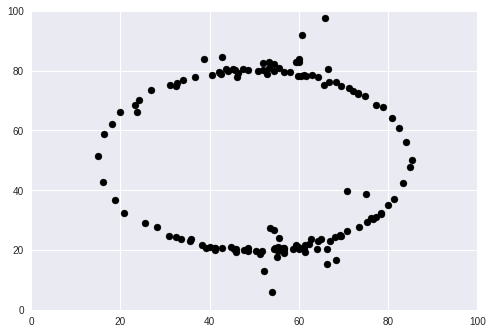

In [148]:

scatter(sa.history[i], col='black')
i += 800
i

#### График целевой функции(по итерациям)

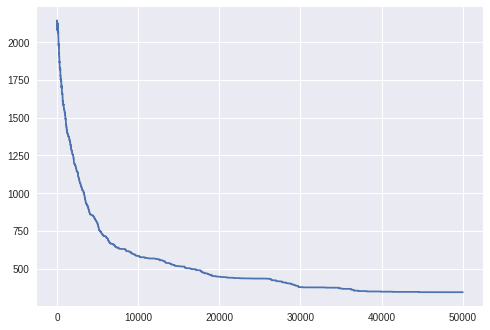

In [142]:
plt.plot(list(range(sa.size)), sa.tarvalues[:sa.size])

#### Проверка совпадения статистик

In [149]:
roundstats(dinostats)

array([54.26, 47.83, 16.71, 26.84, -0.06])

In [150]:
roundstats(getstats(sa.history[49999]))

array([54.26, 47.83, 16.71, 26.84, -0.06])

In [151]:
with open('best.npy', 'wb') as f:
    np.save(f, sa.history)